<a href="https://colab.research.google.com/github/1dhiman/100days-ml/blob/master/2019/11_Unsupervised_Learning_temporal_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install kshape tslearn hdbscan

     |████████████████████████████████| 4.0MB 3.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.22-cp36-cp36m-linux_x86_64.whl size=2336944 sha256=d7baedb9269991ffaff7b35f11d7b65cf0808126398913a57829c22c21f4eeb6
  Stored in directory: /root/.cache/pip/wheels/6d/f9/db/f2e5e704427932f5b05c91fc520effbb0bd10ba8d73fd3bfc7
Successfully built hdbscan


In [7]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from os import listdir, walk
from os.path import isfile, join

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from keras.utils import to_categorical
from sklearn.metrics import adjusted_rand_score
import random

'''Algos'''
from kshape.core import kshape, zscore
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape, TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
import hdbscan

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import LeakyReLU, Reshape, UpSampling2D, Conv2DTranspose
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam, RMSprop
from tensorflow.examples.tutorials.mnist import input_data

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
# Load the datasets
data_train = np.loadtxt("https://raw.githubusercontent.com/Sotera/newman-research/master/time_series_clustering/UCR_time_series_archive_2015/ECGFiveDays/ECGFiveDays_TRAIN", 
                       delimiter=",")
data_test = np.loadtxt("https://raw.githubusercontent.com/Sotera/newman-research/master/time_series_clustering/UCR_time_series_archive_2015/ECGFiveDays/ECGFiveDays_TEST", 
                        delimiter=",")
X_train = to_time_series_dataset(data_train[:, 1:])
y_train = data_train[:, 0].astype(np.int)

X_test = to_time_series_dataset(data_test[:, 1:])
y_test = data_test[:, 0].astype(np.int)

In [9]:
# Basic summary statistics
print("Number of time series:", len(data_train))
print("Number of unique classes:", len(np.unique(data_train[:,0])))
print("Time series length:", len(data_train[0,1:]))

Number of time series: 23
Number of unique classes: 2
Time series length: 136


In [10]:
# Number of examples in each class in the training set
print("Number of time series in class 1.0:", 
      len(data_train[data_train[:,0]==1.0]))
print("Number of time series in class 2.0:", 
      len(data_train[data_train[:,0]==2.0]))

Number of time series in class 1.0: 14
Number of time series in class 2.0: 9


Plot  0  Class  1.0


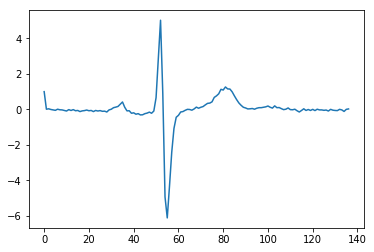

Plot  1  Class  1.0


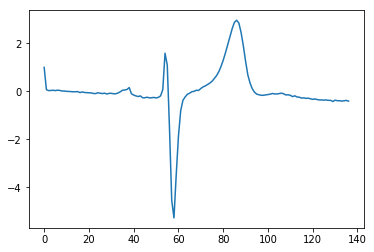

Plot  4  Class  1.0


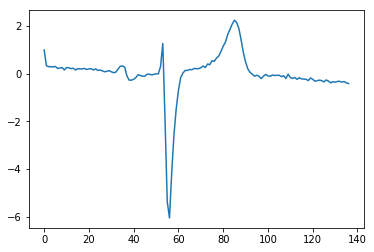

Plot  7  Class  1.0


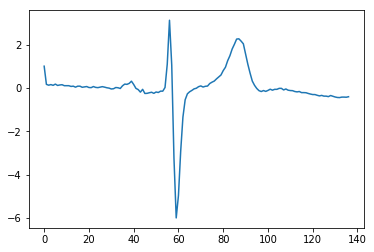

Plot  9  Class  1.0


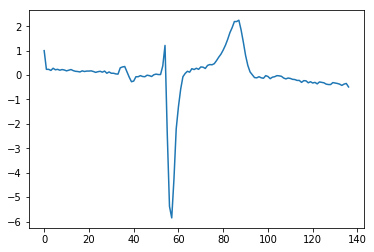

In [11]:
# Examples of Class 1.0
for i in range(0,10):
    if data_train[i,0]==1.0:
        print("Plot ",i," Class ",data_train[i,0])
        plt.plot(data_train[i])
        plt.show()

Plot  2  Class  2.0


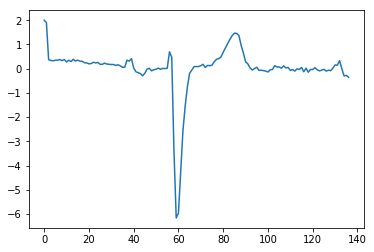

Plot  3  Class  2.0


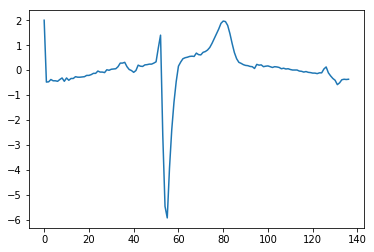

Plot  5  Class  2.0


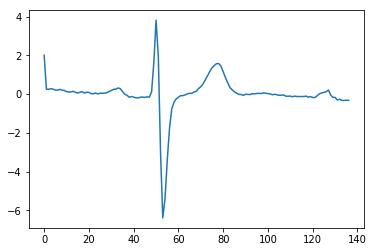

Plot  6  Class  2.0


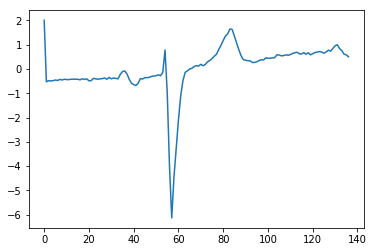

Plot  8  Class  2.0


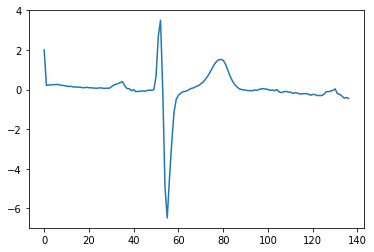

In [12]:
# Examples of Class 2.0
for i in range(0,10):
    if data_train[i,0]==2.0:
        print("Plot ",i," Class ",data_train[i,0])
        plt.plot(data_train[i])
        plt.show()

In [0]:
# Prepare the data - Scale
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_test)

In [14]:
# k-Shape Algorithm

# Train using k-Shape
ks = KShape(n_clusters=2, max_iter=100, n_init=100,verbose=0)
ks.fit(X_train)

KShape(init='random', max_iter=100, n_clusters=2, n_init=100, random_state=None,
       tol=1e-06, verbose=0)

In [15]:
# Make predictions on train set and calculate adjusted Rand index
preds = ks.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index:", ars)

Adjusted Rand Index: 0.668041237113402


In [16]:
# Make predictions on test set and calculate adjusted Rand index
preds_test = ks.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.30370784104540666


In [0]:
# ECG 5000

# Load the datasets
data_train = np.loadtxt("https://raw.githubusercontent.com/Lucklyric/Win2016MM811As5/master/ECG5000_TRAIN", 
                        delimiter=",")

data_test = np.loadtxt("https://raw.githubusercontent.com/Lucklyric/Win2016MM811As5/master/ECG5000_TEST", 
                       delimiter=",")

data_joined = np.concatenate((data_train,data_test),axis=0)
data_train, data_test = train_test_split(data_joined, 
                                    test_size=0.20, random_state=2019)

X_train = to_time_series_dataset(data_train[:, 1:])
y_train = data_train[:, 0].astype(np.int)
X_test = to_time_series_dataset(data_test[:, 1:])
y_test = data_test[:, 0].astype(np.int)

In [18]:
# Summary statistics
print("Number of time series:", len(data_train))
print("Number of unique classes:", len(np.unique(data_train[:,0])))
print("Time series length:", len(data_train[0,1:]))

Number of time series: 4000
Number of unique classes: 5
Time series length: 140


In [19]:
# Calculate number of readings per class
print("Number of time series in class 1.0:", 
      len(data_train[data_train[:,0]==1.0]))
print("Number of time series in class 2.0:", 
      len(data_train[data_train[:,0]==2.0]))
print("Number of time series in class 3.0:", 
      len(data_train[data_train[:,0]==3.0]))
print("Number of time series in class 4.0:", 
      len(data_train[data_train[:,0]==4.0]))
print("Number of time series in class 5.0:", 
      len(data_train[data_train[:,0]==5.0]))

Number of time series in class 1.0: 2327
Number of time series in class 2.0: 1423
Number of time series in class 3.0: 75
Number of time series in class 4.0: 156
Number of time series in class 5.0: 19


 Class  1.0  Count  2327


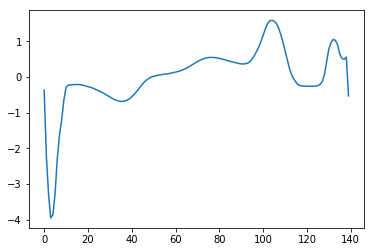

 Class  2.0  Count  1423


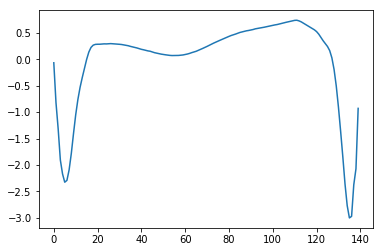

 Class  3.0  Count  75


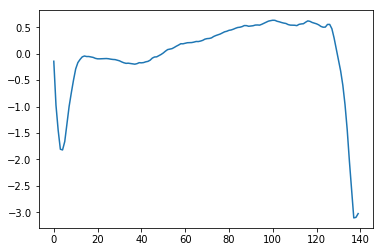

 Class  4.0  Count  156


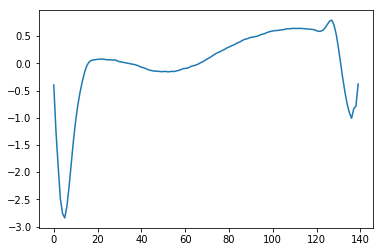

 Class  5.0  Count  19


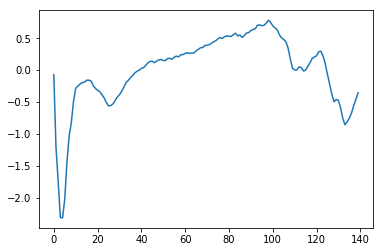

In [20]:
# Display readings from each class
for j in np.unique(data_train[:,0]):
    dataPlot = data_train[data_train[:,0]==j]
    cnt = len(dataPlot)
    dataPlot = dataPlot[:,1:].mean(axis=0)
    print(" Class ",j," Count ",cnt)
    plt.plot(dataPlot)
    plt.show()

In [0]:
# Prepare data - Scale
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_test)

In [22]:
# Train using k-Shape
ks = KShape(n_clusters=5, max_iter=100, n_init=10,verbose=1,random_state=2019)
ks.fit(X_train)

Init 1
0.015 --> 0.015 --> 
Init 2
0.014 --> 0.014 --> 
Init 3
0.018 --> 0.017 --> 0.018 --> 
Init 4
0.017 --> 0.016 --> 0.018 --> 
Init 5
0.016 --> 0.017 --> 
Init 6
0.012 --> 0.012 --> 
Init 7
0.016 --> 0.014 --> 0.016 --> 
Init 8
0.015 --> 0.014 --> 0.015 --> 
Init 9
0.017 --> 0.017 --> 0.018 --> 
Init 10
0.015 --> 0.016 --> 


KShape(init='random', max_iter=100, n_clusters=5, n_init=10, random_state=2019,
       tol=1e-06, verbose=1)

In [23]:
# Predict on train set and calculate adjusted Rand index
preds = ks.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index on Training Set:", ars)

Adjusted Rand Index on Training Set: 0.5553639462811412


In [24]:
# Predict on test set and calculate adjusted Rand index
preds_test = ks.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.5301670526070555


In [25]:
# Evaluate goodness of the clusters
preds_test = preds_test.reshape(1000,1)
preds_test = np.hstack((preds_test,data_test[:,0].reshape(1000,1)))
preds_test = pd.DataFrame(data=preds_test)
preds_test = preds_test.rename(columns={0: 'prediction', 1: 'actual'})

counter = 0
for i in np.sort(preds_test.prediction.unique()):
    print("Predicted Cluster ", i)
    print(preds_test.actual[preds_test.prediction==i].value_counts())
    print()
    cnt = preds_test.actual[preds_test.prediction==i] \
                        .value_counts().iloc[1:].sum()
    counter = counter + cnt
print("Count of Non-Primary Points: ", counter)

Predicted Cluster  0.0
2.0    127
3.0      9
4.0      6
5.0      1
Name: actual, dtype: int64

Predicted Cluster  1.0
2.0    197
1.0     18
4.0      9
3.0      3
Name: actual, dtype: int64

Predicted Cluster  2.0
4.0    18
2.0    18
5.0     3
1.0     2
3.0     2
Name: actual, dtype: int64

Predicted Cluster  3.0
1.0    130
3.0      3
4.0      2
5.0      1
2.0      1
Name: actual, dtype: int64

Predicted Cluster  4.0
1.0    442
3.0      4
4.0      3
2.0      1
Name: actual, dtype: int64

Count of Non-Primary Points:  86


In [26]:
# Time Series k-Means

# Train using Time Series k-Means
km = TimeSeriesKMeans(n_clusters=5, max_iter=100, n_init=100, \
                      metric="euclidean", verbose=1, random_state=2019)
km.fit(X_train)

Init 1
36.241 --> 27.298 --> 26.273 --> 25.556 --> 25.120 --> 24.911 --> 24.831 --> 24.815 --> 24.813 --> 24.812 --> 24.812 --> 24.812 --> 24.812 --> 
Init 2
37.226 --> 25.264 --> 24.680 --> 24.430 --> 24.296 --> 24.202 --> 24.155 --> 24.136 --> 24.128 --> 24.124 --> 24.121 --> 24.119 --> 24.118 --> 24.117 --> 24.117 --> 24.117 --> 24.117 --> 24.116 --> 24.116 --> 24.116 --> 24.116 --> 24.115 --> 24.115 --> 24.115 --> 24.114 --> 24.113 --> 24.112 --> 24.111 --> 24.110 --> 24.109 --> 24.108 --> 24.108 --> 24.108 --> 
Init 3
33.738 --> 25.341 --> 25.014 --> 24.795 --> 24.664 --> 24.623 --> 24.616 --> 24.615 --> 24.614 --> 24.614 --> 24.614 --> 
Init 4
30.531 --> 24.956 --> 24.740 --> 24.663 --> 24.629 --> 24.615 --> 24.603 --> 24.595 --> 24.585 --> 24.567 --> 24.560 --> 24.559 --> 24.559 --> 24.559 --> 24.559 --> 24.559 --> 24.559 --> 
Init 5
34.030 --> 25.598 --> 25.398 --> 25.344 --> 25.310 --> 25.277 --> 25.236 --> 25.159 --> 25.005 --> 24.834 --> 24.725 --> 24.666 --> 24.636 --> 24.6

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=100,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=5, n_init=100, n_jobs=None,
                 random_state=2019, tol=1e-06, verbose=1)

In [27]:
# Predict on training set and evaluate using adjusted Rand index
preds = km.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index of Time Series k-Means on Training Set:", ars)

Adjusted Rand Index of Time Series k-Means on Training Set: 0.5063464656715959


In [28]:
# Predict on test set and evaluate using adjusted Rand index
preds_test = km.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index of Time Series k-Means on Test Set:", ars)

Adjusted Rand Index of Time Series k-Means on Test Set: 0.4864981997585834


In [29]:
# HDBSCAN

# Train model and evaluate on training set
min_cluster_size = 5
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'
prediction_data = True

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
                      min_samples=min_samples, alpha=alpha, \
                      cluster_selection_method=cluster_selection_method, \
                      prediction_data=prediction_data)

preds = hdb.fit_predict(X_train.reshape(4000,140))
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index on Training Set:", ars)

Adjusted Rand Index on Training Set: 0.7689563655060421


In [30]:
# Predict on test set and evaluate
preds_test = hdbscan.prediction.approximate_predict( \
                hdb, X_test.reshape(1000,140))
ars = adjusted_rand_score(data_test[:,0],preds_test[0])
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.7200816245545564
